# Fake NEWS detection 

## Importing libraries 

In [1]:
#Basic libraries
import pandas as pd 
import numpy as np 

#Visualization libraries
import matplotlib.pyplot as plt 
from matplotlib import rcParams
import seaborn as sns
from textblob import TextBlob
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

#NLTK libraries
import nltk
import re
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# Machine Learning libraries
import sklearn 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
 

#Metrics libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#Miscellanous libraries
from collections import Counter

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Deep learning libraries
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

## Reading the datasets ..

In [2]:
#reading the fake and true datasets
fake_news = pd.read_csv('Fake.csv')
true_news = pd.read_csv('True.csv')

# print shape of fake dataset with rows and columns and information 
print ("The shape of the  data is (row, column):"+ str(fake_news.shape))
print (fake_news.info())
print("\n --------------------------------------- \n")

# print shape of true dataset with rows and columns and information
print ("The shape of the  data is (row, column):"+ str(true_news.shape))
print (true_news.info())

The shape of the  data is (row, column):(23481, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB
None

 --------------------------------------- 

The shape of the  data is (row, column):(21417, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB
None


## Pre-processing...

In [3]:
#Target variable for fake news
fake_news['output']=0

#Target variable for true news
true_news['output']=1
#Concatenating and dropping for fake news
fake_news['news']=fake_news['title']+fake_news['text']
fake_news=fake_news.drop(['title', 'text'], axis=1)

#Concatenating and dropping for true news
true_news['news']=true_news['title']+true_news['text']
true_news=true_news.drop(['title', 'text'], axis=1)

#Rearranging the columns
fake_news = fake_news[['subject', 'date', 'news','output']]
true_news = true_news[['subject', 'date', 'news','output']]

In [4]:
fake_news['date'].value_counts()

May 10, 2017         46
May 26, 2016         44
May 6, 2016          44
May 5, 2016          44
May 11, 2016         43
                     ..
December 9, 2017      1
December 4, 2017      1
November 19, 2017     1
November 20, 2017     1
Jul 19, 2015          1
Name: date, Length: 1681, dtype: int64

In [5]:
## Removing links and headlines from the date column

In [6]:
fake_news=fake_news[~fake_news.date.str.contains("http")]
fake_news=fake_news[~fake_news.date.str.contains("HOST")]

'''You can also execute the below code to get the result 
which allows only string which has the months and rest are filtered'''
#fake_news=fake_news[fake_news.date.str.contains("Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec")]

'You can also execute the below code to get the result \nwhich allows only string which has the months and rest are filtered'

In [7]:
##converting dates to date and time format
fake_news['date'] = pd.to_datetime(fake_news['date'])
true_news['date'] = pd.to_datetime(true_news['date'])

In [8]:
frames = [fake_news, true_news]
news_dataset = pd.concat(frames)
news_dataset

,subject,date,news,output
0,News,2017-12-31,Donald Trump Sends Out Embarrassing New Year’...,0
1,News,2017-12-31,Drunk Bragging Trump Staffer Started Russian ...,0
2,News,2017-12-30,Sheriff David Clarke Becomes An Internet Joke...,0
3,News,2017-12-29,Trump Is So Obsessed He Even Has Obama’s Name...,0
4,News,2017-12-25,Pope Francis Just Called Out Donald Trump Dur...,0
...,...,...,...,...
21412,worldnews,2017-08-22,'Fully committed' NATO backs new U.S. approach...,1
21413,worldnews,2017-08-22,LexisNexis withdrew two products from Chinese ...,1
21414,worldnews,2017-08-22,Minsk cultural hub becomes haven from authorit...,1
21415,worldnews,2017-08-22,Vatican upbeat on possibility of Pope Francis ...,1


In [9]:
clean_news=news_dataset.copy()

In [10]:
#cleaning the data using regular expression library
def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [11]:
clean_news['news']=clean_news['news'].apply(lambda x:review_cleaning(x))
clean_news.head()

,subject,date,news,output
0,News,2017-12-31,donald trump sends out embarrassing new year’...,0
1,News,2017-12-31,drunk bragging trump staffer started russian ...,0
2,News,2017-12-30,sheriff david clarke becomes an internet joke...,0
3,News,2017-12-29,trump is so obsessed he even has obama’s name...,0
4,News,2017-12-25,pope francis just called out donald trump dur...,0


## Stopwords..

In [12]:
##A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine has been programmed to ignore, both when indexing entries for searching and when retrieving them as the result of a search query. 

In [13]:
stop = stopwords.words('english')
clean_news['news'] = clean_news['news'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
clean_news.head()

,subject,date,news,output
0,News,2017-12-31,donald trump sends embarrassing new year’s eve...,0
1,News,2017-12-31,drunk bragging trump staffer started russian c...,0
2,News,2017-12-30,sheriff david clarke becomes internet joke thr...,0
3,News,2017-12-29,trump obsessed even obama’s name coded website...,0
4,News,2017-12-25,pope francis called donald trump christmas spe...,0


## Data Visualization for better understanding.

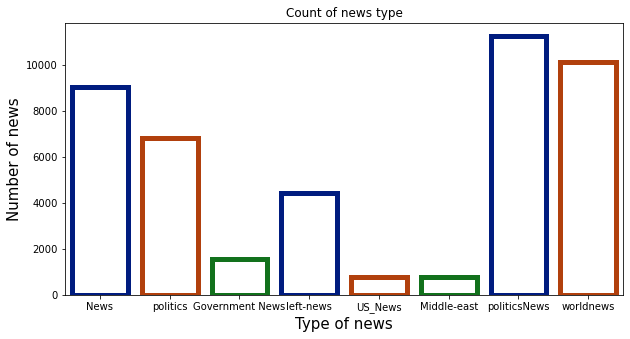

In [14]:
#Plotting the frequency plot
ax = sns.countplot(x="subject", data=clean_news,
                   facecolor=(0, 0, 0, 0),
                   linewidth=5,
                   edgecolor=sns.color_palette("dark", 3))

#Setting labels and font size
ax.set(xlabel='Type of news', ylabel='Number of news',title='Count of news type')
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)

## fake news vs True news

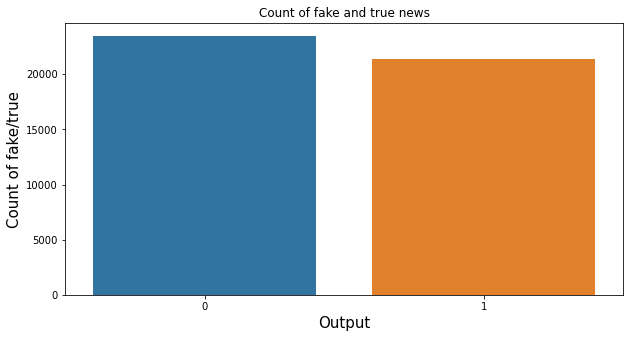

In [15]:
ax=sns.countplot(x="output", data=clean_news)

#Setting labels and font size
ax.set(xlabel='Output', ylabel='Count of fake/true',title='Count of fake and true news')
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)

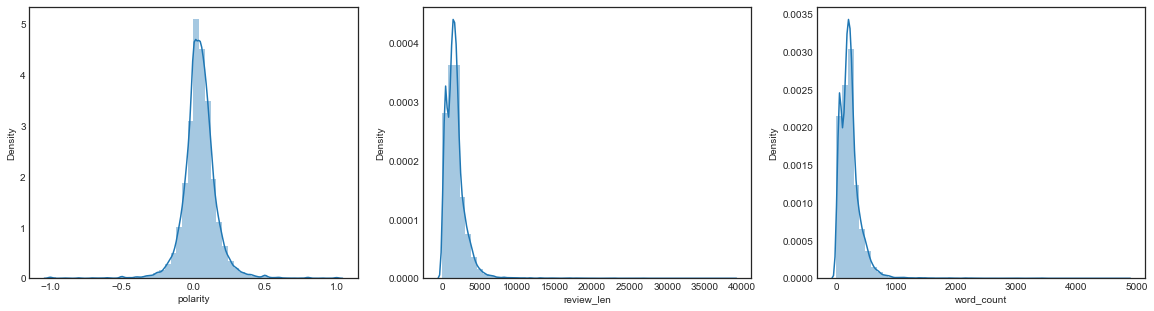

In [16]:
#Extracting the features from the news
clean_news['polarity'] = clean_news['news'].map(lambda text: TextBlob(text).sentiment.polarity)
clean_news['review_len'] = clean_news['news'].astype(str).apply(len)
clean_news['word_count'] = clean_news['news'].apply(lambda x: len(str(x).split()))

#Plotting the distribution of the extracted feature
plt.figure(figsize = (20, 5))
plt.style.use('seaborn-white')
plt.subplot(131)
sns.distplot(clean_news['polarity'])
fig = plt.gcf()
plt.subplot(132)
sns.distplot(clean_news['review_len'])
fig = plt.gcf()
plt.subplot(133)
sns.distplot(clean_news['word_count'])
fig = plt.gcf()

## N-Gram Analysis
## Top 20 words in News based on frequency

In [17]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(clean_news['news'], 20)
for word, freq in common_words:
    print(word, freq)

#Creating the dataframe of word and frequency ., ., .
df1 = pd.DataFrame(common_words, columns = ['news' , 'count'])

#Group by words and plot the sum of words ....
df1.groupby('news').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in news')


trump 140400
said 130258
us 68081
would 55422
president 53189
people 41718
one 36146
state 33190
new 31799
also 31209
obama 29881
clinton 29003
house 28716
government 27392
donald 27376
reuters 27348
states 26331
republican 25287
could 24356
white 23823


# WordCloud of Fake news and True News

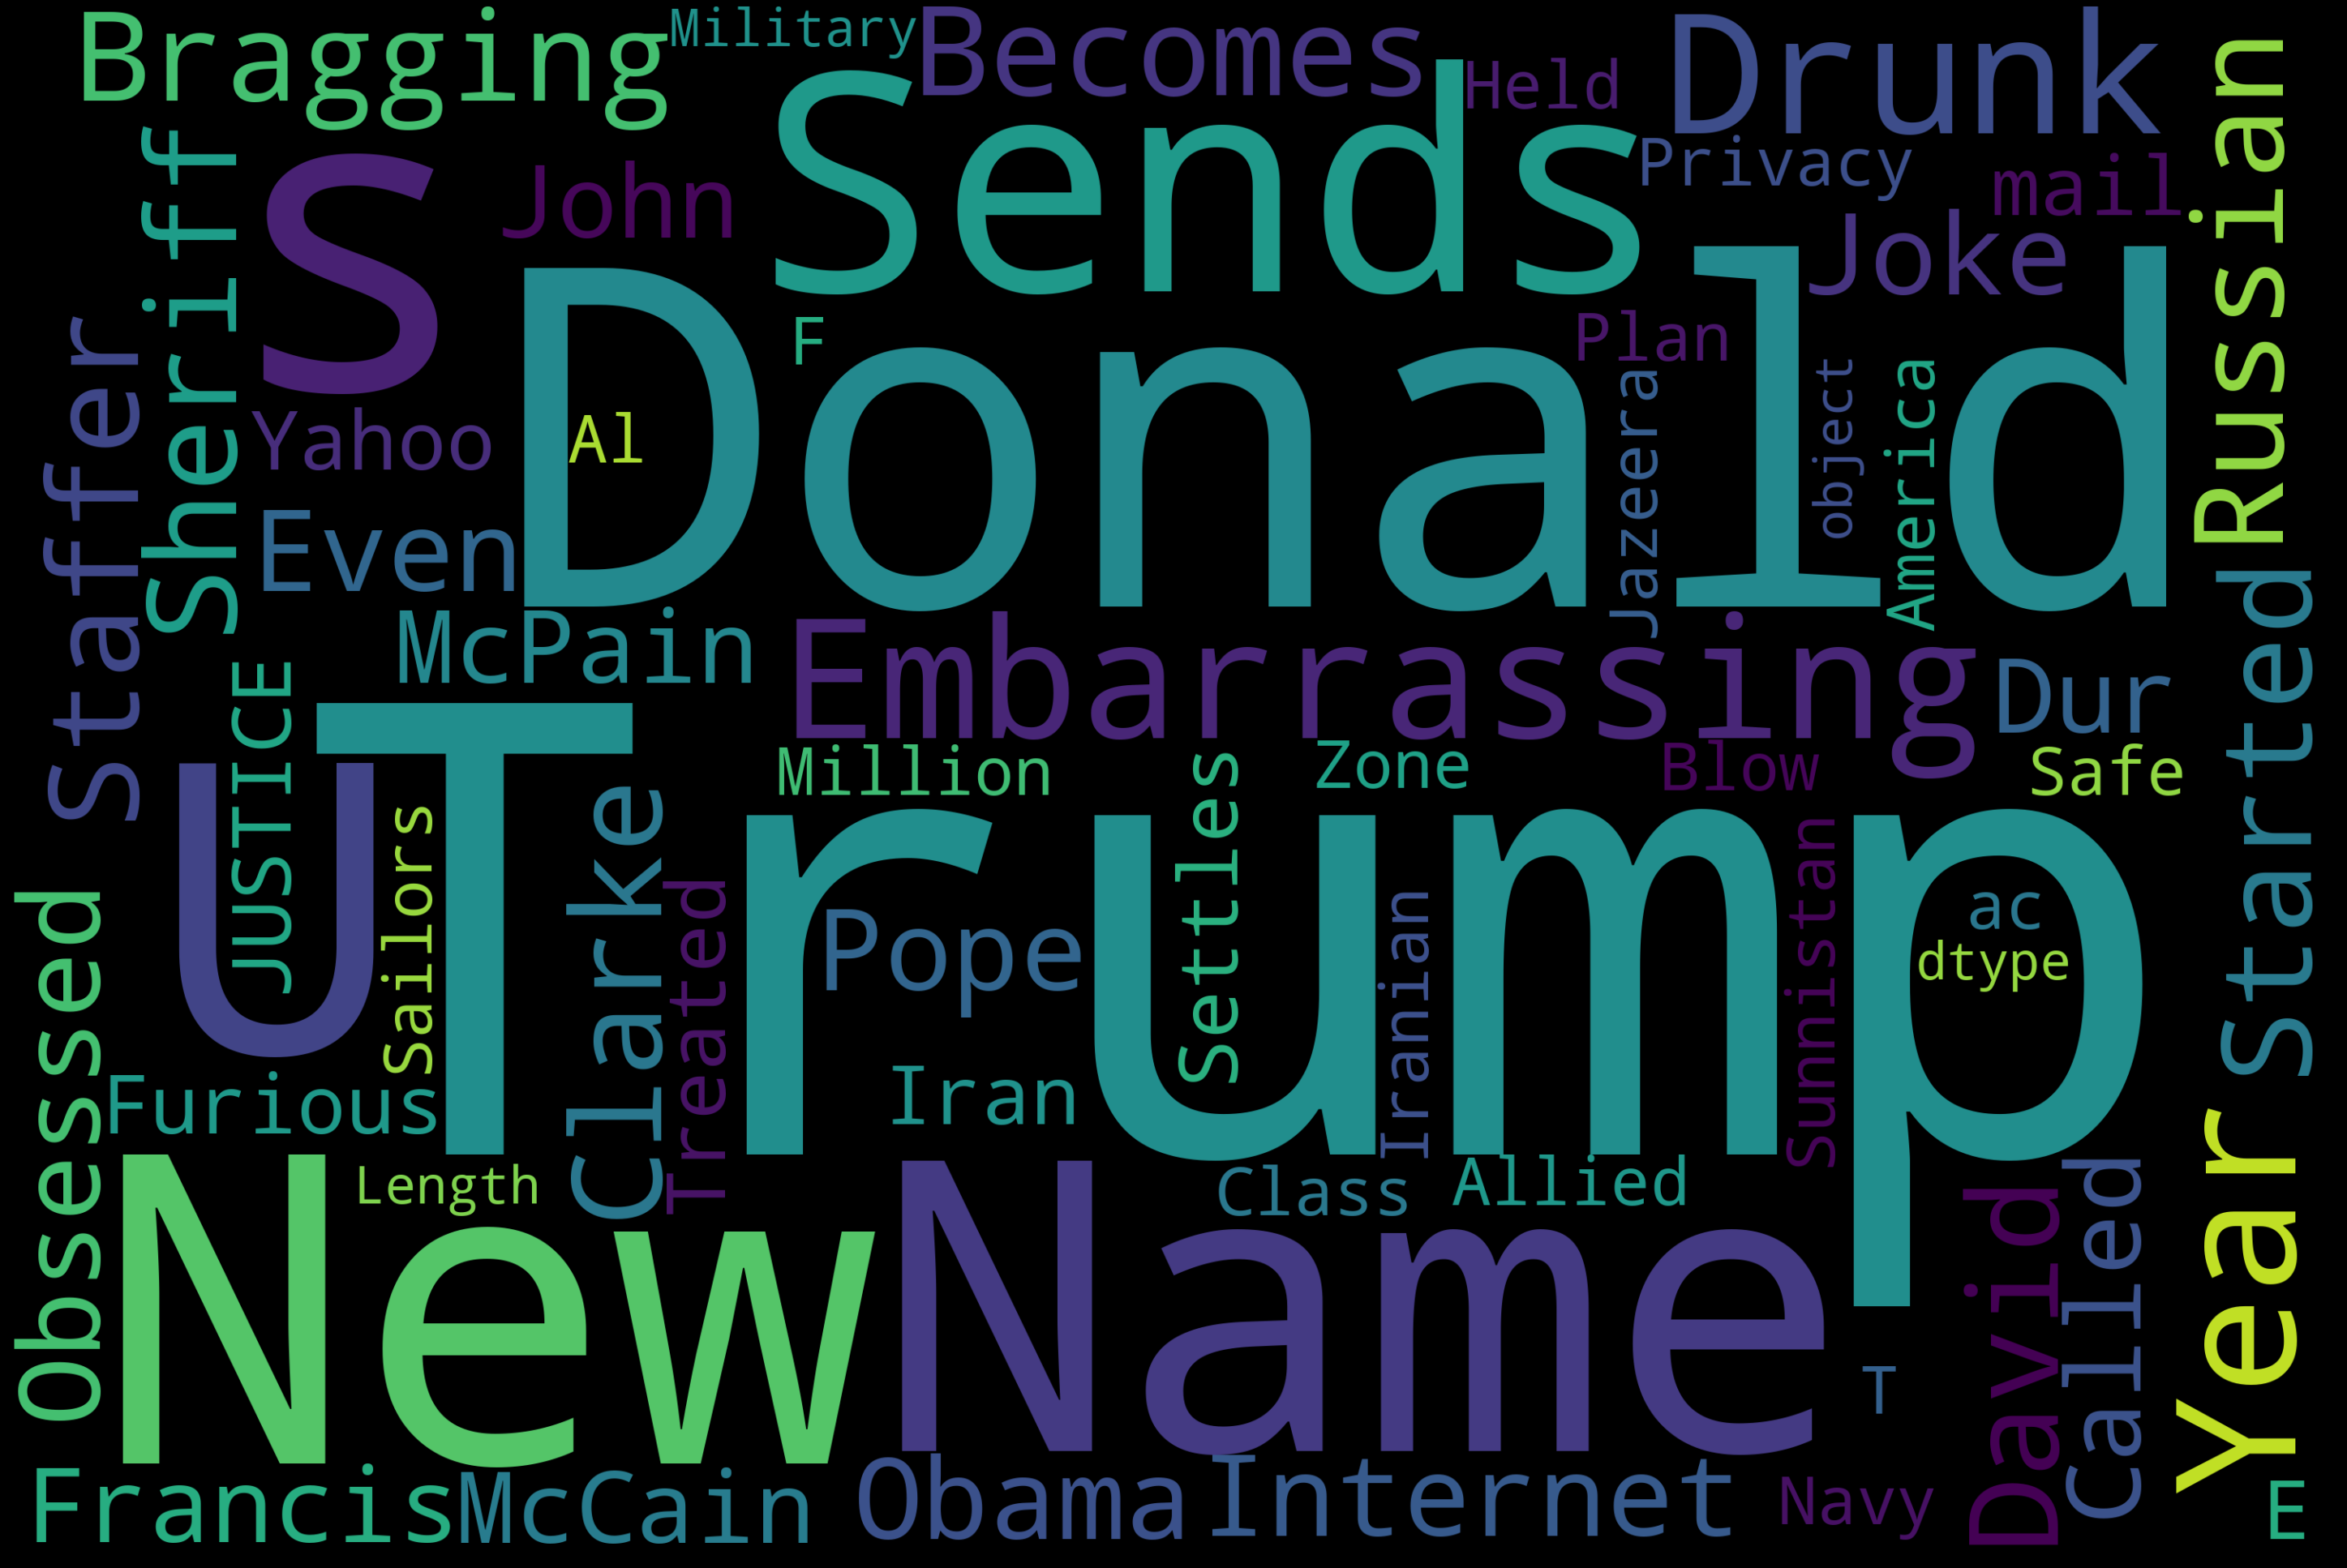

In [18]:
text = fake_news["news"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## True news wordcloud

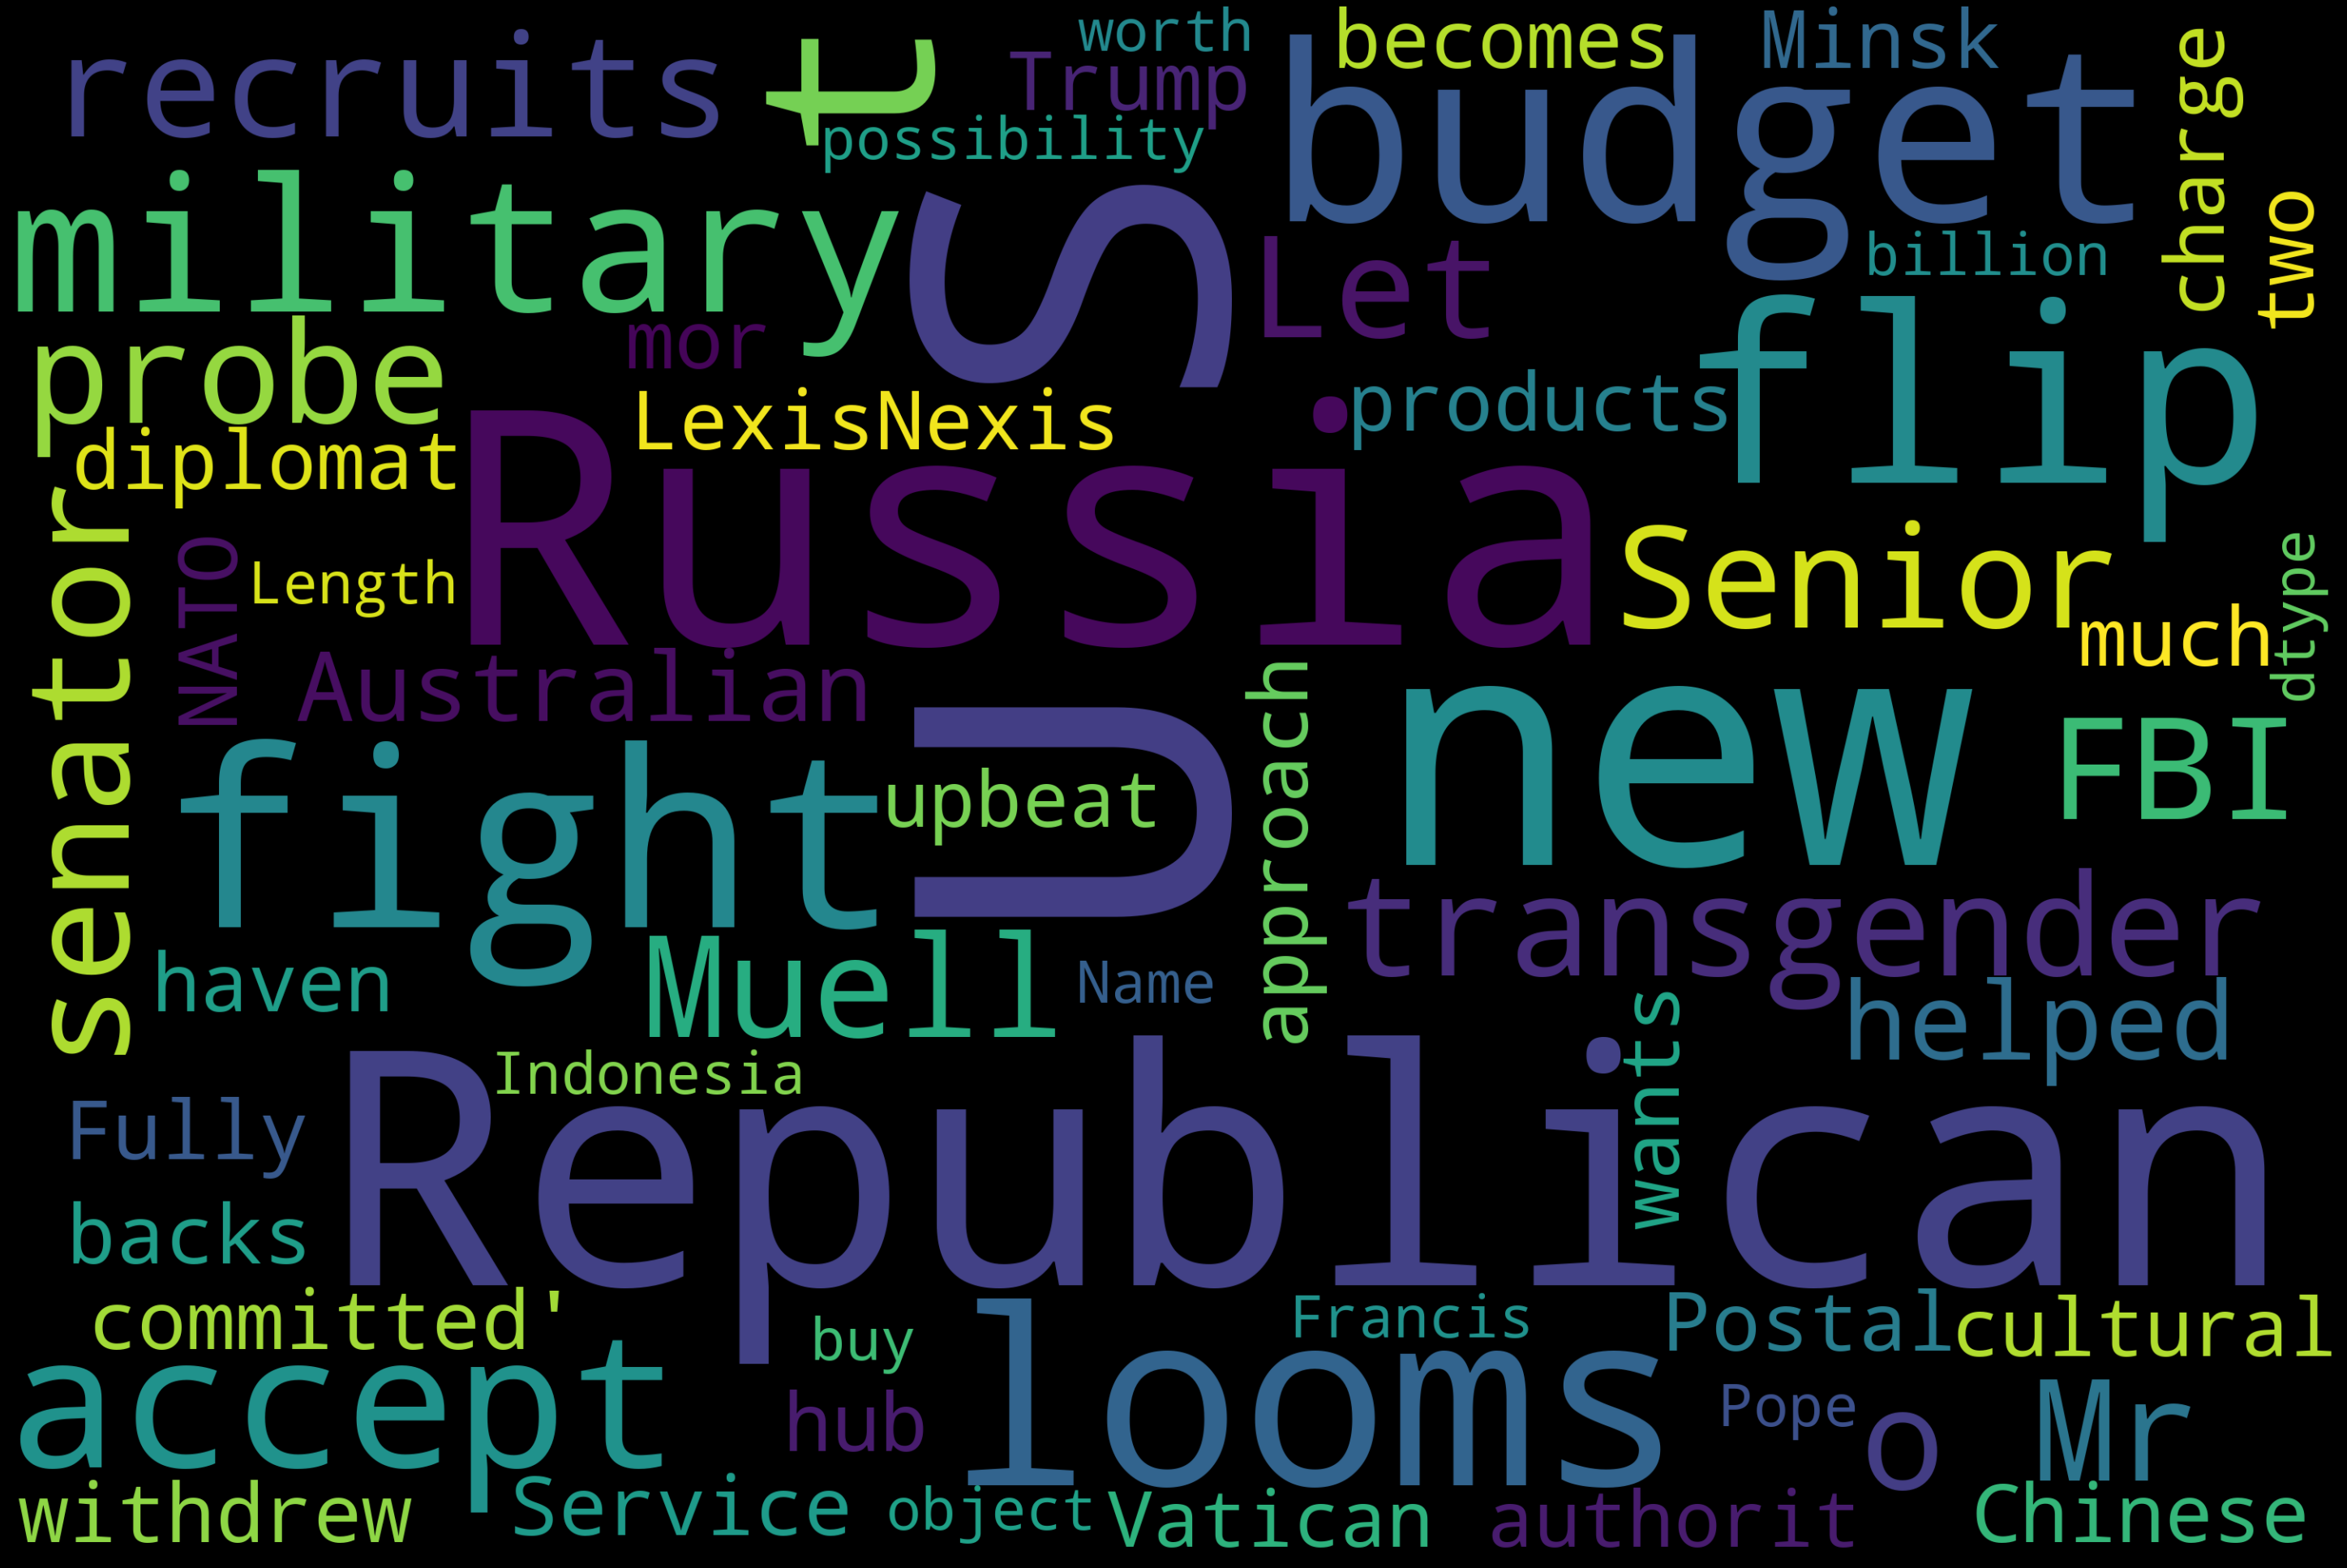

In [19]:
text = true_news["news"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# Stemming & Vectorizing

In [20]:
# Stemming is a method of deriving root word from the inflected word. Here we extract the reviews and convert the words in reviews to its root word. 

In [21]:
news_features=clean_news.copy()
news_features=news_features[['news']].reset_index(drop=True)
news_features.head()

,news
0,donald trump sends embarrassing new year’s eve...
1,drunk bragging trump staffer started russian c...
2,sheriff david clarke becomes internet joke thr...
3,trump obsessed even obama’s name coded website...
4,pope francis called donald trump christmas spe...


In [22]:
stop_words = set(stopwords.words("english"))
#Performing stemming on the review dataframe
ps = PorterStemmer()

#splitting and adding the stemmed words except stopwords
corpus = []
for i in range(0, len(news_features)):
    news = re.sub('[^a-zA-Z]', ' ', news_features['news'][i])
    news= news.lower()
    news = news.split()
    news = [ps.stem(word) for word in news if not word in stop_words]
    news = ' '.join(news)
    corpus.append(news)

In [23]:
corpus[1]

'drunk brag trump staffer start russian collus investigationhous intellig committe chairman devin nune go bad day assumpt like mani us christoph steeledossi prompt russia investig lash depart justic fbi order protect trump happen dossier start investig accord document obtain new york timesform trump campaign advis georg papadopoulo drunk wine bar reveal knowledg russian opposit research hillari clintonon top papadopoulo covfef boy trump administr alleg much larger role none damn drunken fool wine bar coffe boy help arrang new york meet trump presid abdel fattah elsisi egypt two month elect known former aid set meet world leader trump team trump ran mere coffe boyin may papadopoulo reveal australian diplomat alexand downer russian offici shop around possibl dirt thendemocrat presidenti nomine hillari clinton exactli much mr papadopoulo said night kensington wine room australian alexand downer unclear report state two month later leak democrat email began appear onlin australian offici p

# TFIDF(Term Frequency — Inverse Document Frequency)

In [24]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(2,2))
# TF-IDF feature matrix
X= tfidf_vectorizer.fit_transform(news_features['news'])
X.shape

(44888, 5000)

In [25]:
y=clean_news['output']

In [26]:
print(f'Original dataset shape : {Counter(y)}')

Original dataset shape : Counter({0: 23471, 1: 21417})


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [28]:
#model building , confusion matrix

In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## MODEL Selection

In [30]:
#creating the objects
logreg_cv = LogisticRegression(random_state=0)
dt_cv=DecisionTreeClassifier()
knn_cv=KNeighborsClassifier()
nb_cv=MultinomialNB(alpha=0.1) 
cv_dict = {0: 'Logistic Regression', 1: 'Decision Tree',2:'KNN',3:'Naive Bayes'}
cv_models=[logreg_cv,dt_cv,knn_cv,nb_cv]

#Printing the accuracy
for i,model in enumerate(cv_models):
    print("{} Test Accuracy: {}".format(cv_dict[i],cross_val_score(model, X, y, cv=10, scoring ='accuracy').mean()))

Logistic Regression Test Accuracy: 0.9660040199274997
Decision Tree Test Accuracy: 0.9340128563424397
KNN Test Accuracy: 0.613172841991654
Naive Bayes Test Accuracy: 0.9373328405462511


In [31]:
#as we can clearly see that logistic regression has outperform every other model.

## Logistic Regression with Hyperparameter Tuning

In [32]:
param_grid = {'C': np.logspace(-4, 4, 50),
             'penalty':['l1', 'l2']}
clf = GridSearchCV(LogisticRegression(random_state=0), param_grid,cv=5, verbose=0,n_jobs=-1)
best_model = clf.fit(X_train,y_train)
print(best_model.best_estimator_)
print("The mean accuracy of the model is:",best_model.score(X_test,y_test))

LogisticRegression(C=11.513953993264458, random_state=0)
The mean accuracy of the model is: 0.9807306749832925


this is a biased dataset,so we can easily getting high accuracy.But for classification proble , we must check Confusion matrix.


## Confusion Matrix

In [34]:
logreg = LogisticRegression(C=24.420530945486497, random_state=0)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.98


Confusion matrix, without normalization


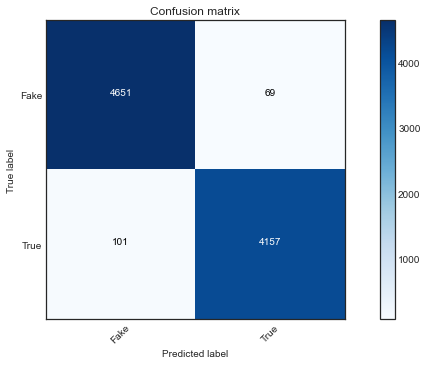

In [35]:
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['Fake','True'])

## Classification Report

In [36]:
print("Classification Report:\n",classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      4720
           1       0.98      0.98      0.98      4258

    accuracy                           0.98      8978
   macro avg       0.98      0.98      0.98      8978
weighted avg       0.98      0.98      0.98      8978



## ROC - AUC curve

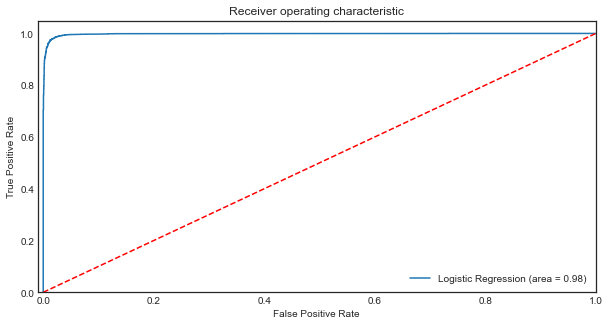

In [37]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

We should consider the AUC score which is 98%.
Thanks For coming so Far..... Thank You.